In [1]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# 2. Machine Learning

## 2.3 Classification

### 2.3.1 MNIST Dataset

The MNIST dataset is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents. This set has been studied so much that it is often called the “hello world” of machine learning: whenever people come up with a new classification algorithm they are curious to see how it will perform on MNIST, and anyone who learns machine learning tackles this dataset sooner or later.

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)

In [3]:
print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [5]:
print(mnist.keys())

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])


In [6]:
X, y = mnist.data, mnist.target
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(70000, 784))

In [7]:
X.shape

(70000, 784)

In [8]:
y

array(['5', '0', '4', ..., '4', '5', '6'], shape=(70000,), dtype=object)

In [9]:
y.shape

(70000,)

There are 70,000 images, and each image has 784 features. This is because each image is 28 × 28 pixels, and each feature simply represents one pixel’s intensity, from 0 (white) to 255 (black). 

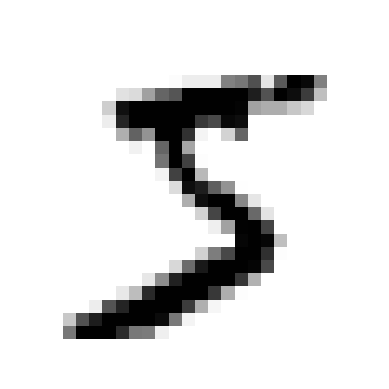

In [10]:
def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

some_digit = X[0]
plot_digit(some_digit)

plt.show()

In [11]:
y[0]

'5'

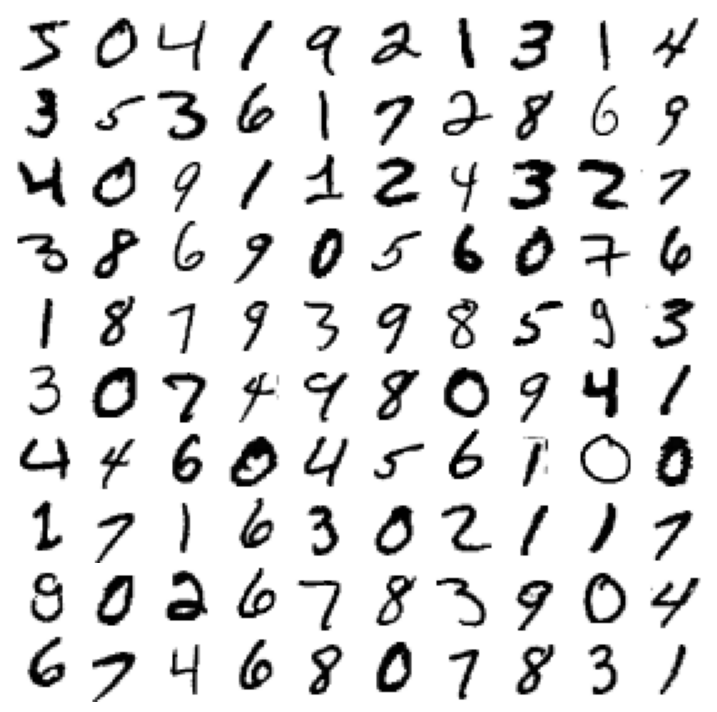

In [12]:
# extra code
plt.figure(figsize=(9, 9))
for idx, image_data in enumerate(X[:100]):
    plt.subplot(10, 10, idx + 1)
    plot_digit(image_data)
plt.subplots_adjust(wspace=0, hspace=0)

plt.show()

The MNIST dataset returned by `fetch_openml()` is actually already split into a training set (the first 60,000 images) and a test set (the last 10,000 images).

The training set is already shuffled for us, which is good because this guarantees that all cross-validation folds will be similar (we don’t want one fold to be missing some digits). Moreover, some learning algorithms are sensitive to the order of the training instances, and they perform poorly if they get many similar instances in a row. Shuffling the dataset ensures that this won’t happen.

In [13]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### 2.3.2 Training a Binary Classifier

Let’s simplify the problem for now and only try to identify one digit—for example, the number 5. This “5-detector” will be an example of a binary classifier, capable of distinguishing between just two classes, 5 and non-5.

In [14]:
y_train_5 = (y_train == '5')  # True for all 5s, False for all other digits
y_test_5 = (y_test == '5')

Now let’s pick a classifier and train it. A good place to start is with a stochastic gradient descent (SGD, or stochastic GD) classifier, using Scikit-Learn’s `SGDClassifier` class. This classifier is capable of handling very large datasets efficiently. This is in part because SGD deals with training instances independently, one at a time, which also makes SGD well suited for online learning, as you will see later. Let’s create an `SGDClassifier` and train it on the whole training set:

In [15]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

,loss,'hinge'
,penalty,'l2'
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,1000
,tol,0.001
,shuffle,True
,verbose,0
,epsilon,0.1
,n_jobs,None


In [16]:
sgd_clf.predict([some_digit])

array([ True])

The classifier guesses that this image represents a 5 (True). Looks like it guessed right in this particular case! Now, let’s evaluate this model’s performance.

### 2.3.3 Performance Measures

#### 2.3.3.1 Measuring Accuracy Using Cross-Validation

**Accuracy** is the proportion of all classifications that were correct, whether positive or negative. It is mathematically defined as:

$$\text{Accuracy} =  \frac{\text{correct classifications}}{\text{total classifications}} = \frac{\text{TP} + \text{TN}}{\text{TP} + \text{TN} + \text{FP} + \text{FN}}$$

Let’s use the `cross_val_score()` function to evaluate our `SGDClassifier` model, using k-fold cross-validation with three folds. Remember that k-fold cross-validation means splitting the training set into k folds (in this case, three), then training the model k times, holding out a different fold each time for evaluation.

In [20]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)  # add shuffle=True if the dataset is
                                       # not already shuffled
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))  # prints 0.95035, 0.96035, and 0.9604

0.95035
0.96035
0.9604


Alternatively can use the `cross_val_score()` function to perform the same cross-validation more easily:

```python
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")
```

Let’s look at a dummy classifier that just classifies every single image in the most frequent class, which in this case is the negative class (i.e., non-5):

In [18]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train)))

False


In [19]:
from sklearn.model_selection import cross_val_score

cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

It has over 90% accuracy! This is simply because only about 10% of the images are 5s, so if you always guess that an image is not a 5, you will be right about 90% of the time.

This demonstrates why accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with imbalanced datasets (i.e., when some classes are much more frequent than others). A much better way to evaluate the performance of a classifier is to look at the confusion matrix (CM).

#### 2.3.3.2 Confusion Matrix

![Confusion Matrix](./img/cm.png)

To compute the confusion matrix, you first need to have a set of predictions so that they can be compared to the actual targets. You could make predictions on the test set, but it’s best to keep that untouched for now (remember that you want to use the test set only at the very end of your project, once you have a classifier that you are ready to launch). Instead, you can use the `cross_val_predict()` function:

In [23]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Just like the `cross_val_score()` function, `cross_val_predict()` performs k-fold cross-validation, but instead of returning the evaluation scores, it returns the predictions made on each test fold. This means that you get a clean prediction for each instance in the training set (by “clean” we mean “out-of-sample”: the model makes predictions on data that it never saw during training).

Now you are ready to get the confusion matrix using the `confusion_matrix()` function. Just pass it the target classes `(y_train_5)` and the predicted classes `(y_train_pred)`:

In [24]:
y_train_pred

array([ True, False, False, ...,  True, False, False], shape=(60000,))

In [25]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]])

Each row in a confusion matrix represents an actual class, while each column represents a predicted class. The first row of this matrix considers non-5 images (the negative class): 53,892 of them were correctly classified as non-5s (they are called true negatives), while the remaining 687 were wrongly classified as 5s (false positives, also called type I errors). The second row considers the images of 5s (the positive class): 1,891 were wrongly classified as non-5s (false negatives, also called type II errors), while the remaining 3,530 were correctly classified as 5s (true positives). A perfect classifier would only have true positives and true negatives, so its confusion matrix would have nonzero values only on its main diagonal (top left to bottom right):

In [26]:
y_train_perfect_predictions = y_train_5  # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

#### 2.3.3.3 Recall, Precision, FPR and F1 Score

**Recall** (also called sensitivity or true positive rate) is the proportion of all actual positive instances that were correctly classified. It is mathematically defined as:

$$\text{Recall} =  \frac{\text{correctly classified actual positives}}{\text{all actual positives}} = \frac{\text{TP}}{\text{TP} + \text{FN}}$$

A hypothetical perfect model would have zero false negatives and therefore a recall (TPR) of 1.0, which is to say, a 100% detection rate.

In an imbalanced dataset where the number of actual positives is very low, recall is a more meaningful metric than accuracy because it measures the ability of the model to correctly identify all positive instances. For applications like disease prediction, correctly identifying the positive cases is crucial. A false negative typically has more serious consequences than a false positive.

**False Positive Rate (FPR)** is the proportion of all actual negatives that were classified incorrectly as positives, also known as the probability of false alarm. It is mathematically defined as:

$$\text{FPR} =  \frac{\text{incorrectly classified actual negatives}}{\text{all actual negatives}} = \frac{\text{FP}}{\text{FP} + \text{TN}}$$

A perfect model would have zero false positives and therefore a FPR of 0.0, which is to say, a 0% false alarm rate.

In an imbalanced dataset where the number of actual negatives is very, very low, say 1-2 examples in total, FPR is less meaningful and less useful as a metric.

**Precision** is the proportion of all the model's positive classifications that are actually positive. It is mathematically defined as:

$$\text{Precision} =  \frac{\text{correctly classified actual positives}}{\text{everything classified as positive}} = \frac{\text{TP}}{\text{TP} + \text{FP}}$$

A hypothetical perfect model would have zero false positives and therefore a precision of 1.0.

In an imbalanced dataset where the number of actual positives is very, very low, say 1-2 examples in total, precision is less meaningful and less useful as a metric.

Precision improves as false positives decrease, while recall improves when false negatives decrease. But as seen in the previous section, increasing the classification threshold tends to decrease the number of false positives and increase the number of false negatives, while decreasing the threshold has the opposite effects. As a result, precision and recall often show an inverse relationship, where improving one of them worsens the other.

**F1 Score** is the harmonic mean of precision and recall, providing a single metric that balances both concerns. It is mathematically defined as:

$$\text{F1} =  2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}} = \frac{2\text{TP}}{2\text{TP}+\text{FP}+\text{FN}}$$

This metric balances the importance of precision and recall, and is preferable to accuracy for class-imbalanced datasets. When precision and recall both have perfect scores of 1.0, F1 will also have a perfect score of 1.0. More broadly, when precision and recall are close in value, F1 will be close to their value. When precision and recall are far apart, F1 will be similar to whichever metric is worse.

In [27]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)  # == 3530 / (687 + 3530)

0.8370879772350012

In [28]:
recall_score(y_train_5, y_train_pred)  # == 3530 / (1891 + 3530)

0.6511713705958311

Now our 5-detector does not look as shiny as it did when we looked at its accuracy. When it claims an image represents a 5, it is correct only 83.7% of the time. Moreover, it only detects 65.1% of the 5s.

In [29]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343847

The F1 score favors classifiers that have similar precision and recall. This is not always what you want: in some contexts you mostly care about precision, and in other contexts you really care about recall. For example, if you trained a classifier to detect videos that are safe for kids, you would probably prefer a classifier that rejects many good videos (low recall) but keeps only safe ones (high precision), rather than a classifier that has a much higher recall but lets a few really bad videos show up in your product (in such cases, you may even want to add a human pipeline to check the classifier’s video selection). On the other hand, suppose you train a classifier to detect shoplifters in surveillance images: it is probably fine if your classifier only has 30% precision as long as it has 99% recall. Sure, the security guards will get a few false alerts, but almost all shoplifters will get caught. Similarly, medical diagnosis usually requires a high recall to avoid missing anything important. False positives can be ruled out by follow-up medical tests.

Unfortunately, you can’t have it both ways: increasing precision reduces recall, and vice versa. This is called the precision/recall trade-off.

#### 2.3.3.4 Choice of metrics and tradeoffs

![Choice of metrics](./img/metrics-choice.png)

To understand the trade-off, let’s look at how the `SGDClassifier` makes its classification decisions. For each instance, it computes a score based on a decision function. If that score is greater than a threshold, it assigns the instance to the positive class; otherwise it assigns it to the negative class. Suppose the decision threshold is positioned at the central arrow (between the two 5s): you will find 4 true positives (actual 5s) on the right of that threshold, and 1 false positive (actually a 6). Therefore, with that threshold, the precision is 80% (4 out of 5). But out of 6 actual 5s, the classifier only detects 4, so the recall is 67% (4 out of 6). If you raise the threshold (move it to the arrow on the right), the false positive (the 6) becomes a true negative, thereby increasing the precision (up to 100% in this case), but one true positive becomes a false negative, decreasing recall down to 50%. Conversely, lowering the threshold increases recall and reduces precision.

![Trade-off](./img/tradeoff.png)

Instead of calling the classifier’s `predict()` method, you can call its `decision_function()` method, which returns a score for each instance. You can then use any threshold you want to make predictions based on those scores:

In [30]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

The `SGDClassifier` uses a threshold equal to 0, so the following code returns the same result as the `predict()` method (i.e., True). Let’s raise the threshold:

In [32]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [33]:
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

This confirms that raising the threshold decreases recall. The image actually represents a 5, and the classifier detects it when the threshold is 0, but it misses it when the threshold is increased to 3,000.

How to decide which threshold to use? One option is to use the `cross_val_predict()` function to get the scores of all instances in the training set, but this time specifying we want to return decision scores instead of predictions:

In [34]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

With these scores, use the `precision_recall_curve()` function to compute precision and recall for all possible thresholds (the function adds a last precision of 1 and a last recall of 0, corresponding to an infinite threshold):

In [35]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

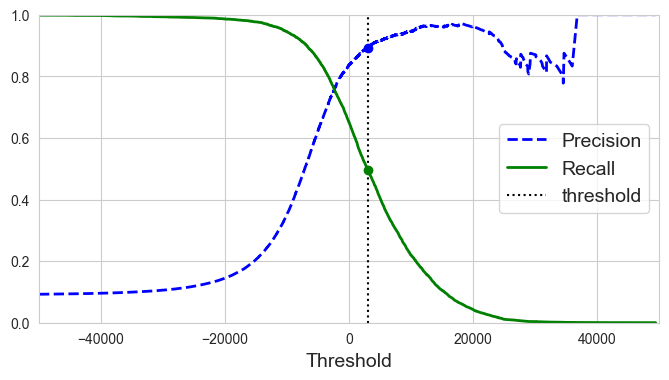

In [38]:
plt.figure(figsize=(8, 4))  # extra code – it's not needed, just formatting
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")

# extra code – this section just beautifies Figure 3–5
idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, 0, 1])
plt.grid(True)
plt.xlabel("Threshold")
plt.legend(loc="center right")

plt.show()

At this threshold value, precision is near 90% and recall is around 50%. Another way to select a good precision/recall trade-off is to plot precision directly against recall.

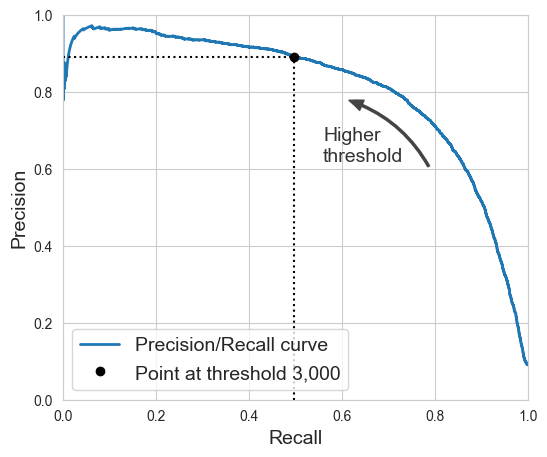

In [39]:
import matplotlib.patches as patches  # extra code – for the curved arrow

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

# extra code – just beautifies Figure 3–6
plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko",
         label="Point at threshold 3,000")
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.legend(loc="lower left")

plt.show()

You can see that precision really starts to fall sharply at around 80% recall. You will probably want to select a precision/recall trade-off just before that drop—for example, at around 60% recall. But of course, the choice depends on your project.

Suppose you decide to aim for 90% precision. You could use the first plot to find the threshold you need to use, but that’s not very precise. Alternatively, you can search for the lowest threshold that gives you at least 90% precision. For this, you can use the NumPy array’s argmax() method. This returns the first index of the maximum value, which in this case means the first True value:

In [40]:
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

np.float64(3370.0194991439557)

In [41]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

In [42]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [43]:
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_at_90_precision

0.4799852425751706

Great, you have a 90% precision classifier! As you can see, it is fairly easy to create a classifier with virtually any precision you want: just set a high enough threshold, and you’re done. But wait, not so fast: a high-precision classifier is not very useful if its recall is too low! For many applications, 48% recall wouldn’t be great at all.

There are two classes you can use to more easily adjust the decision threshold:

* `The FixedThresholdClassifier` class lets you wrap a binary classifier and set the desired threshold manually. If the underlying classifier has a `predict_proba()` method, then the threshold should be a value between 0 and 1 (the default is 0.5). Otherwise, it should be a decision score, comparable to the output of the model’s `decision_function()` (the default is 0).

* The `TunedThresholdClassifierCV` class uses k-fold cross-validation to automatically find the optimal threshold for a given metric. By default, it tries to find the threshold that maximizes the model’s balanced accuracy: that’s the average of each class’s recall. However, you can select another metric to optimize for (see the documentation for the full list of options).

#### 2.3.3.5 ROC and AUC

The **Receiver Operating Characteristic (ROC) curve** is a visual representation of model performance across all thresholds. The long version of the name, receiver operating characteristic, is a holdover from WWII radar detection.

The ROC curve is drawn by calculating the true positive rate (TPR) and false positive rate (FPR) at every possible threshold (in practice, at selected intervals), then graphing TPR over FPR. A perfect model, which at some threshold has a TPR of 1.0 and a FPR of 0.0, can be represented by either a point at (0, 1) if all other thresholds are ignored, or by the following:

![ROC and AUC of a hypothetical perfect model](./img/auc_1-0.png)

The **area under the curve (AUC)** represents the probability that the model, if given a randomly chosen positive and negative example, will rank the positive higher than the negative.

The perfect model above, containing a square with sides of length 1, has an area under the curve (AUC) of 1.0. This means there is a 100% probability that the model will correctly rank a randomly chosen positive example higher than a randomly chosen negative example. In other words, looking at the spread of data points below, AUC gives the probability that the model will place a randomly chosen square to the right of a randomly chosen circle, independent of where the threshold is set.

![A spread of predictions for a binary classification model. AUC is the chance a randomly chosen square is positioned to the right of a randomly chosen circle.](./img/no_slider_data.png)

For a binary classifier, a model that does exactly as well as random guesses or coin flips has a ROC that is a diagonal line from (0,0) to (1,1). The AUC is 0.5, representing a 50% probability of correctly ranking a random positive and negative example.

![ROC and AUC of completely random guesses](./img/auc_0-5.png)

AUC is a useful measure for comparing the performance of two different models, as long as the dataset is roughly balanced. The model with greater area under the curve is generally the better one.

![ROC and AUC of two hypothetical models. The curve on the right, with a greater AUC, represents the better of the two models.](./img/auc_0-65.png)

The points on a ROC curve closest to (0,1) represent a range of the best-performing thresholds for the given model. As discussed in the Thresholds, Confusion matrix and Choice of metric and tradeoffs sections, the threshold you choose depends on which metric is most important to the specific use case. Consider the points A, B, and C in the following diagram, each representing a threshold:

![Three labeled points representing thresholds](./img/auc_abc.png)

If false positives (false alarms) are highly costly, it may make sense to choose a threshold that gives a lower FPR, like the one at point A, even if TPR is reduced. Conversely, if false positives are cheap and false negatives (missed true positives) highly costly, the threshold for point C, which maximizes TPR, may be preferable. If the costs are roughly equivalent, point B may offer the best balance between TPR and FPR.

AUC and ROC work well for comparing models when the dataset is roughly balanced between classes. When the dataset is imbalanced, precision-recall curves (PRCs) and the area under those curves may offer a better comparative visualization of model performance. Precision-recall curves are created by plotting precision on the y-axis and recall on the x-axis across all thresholds.

![PR AUC](./img/prauc.png)

To plot the ROC curve, you first use the roc_curve() function to compute the TPR and FPR for various threshold values:

In [44]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

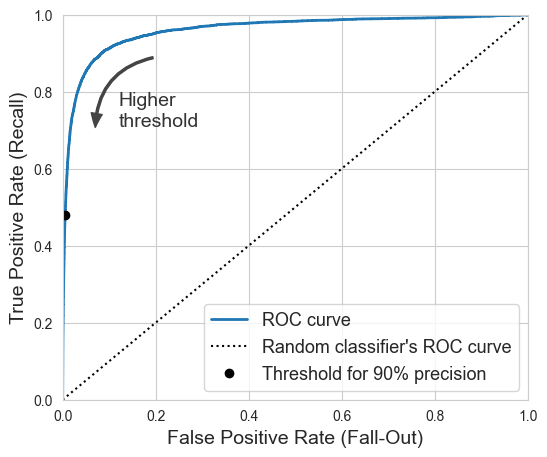

In [46]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

# extra code – just beautifies Figure 3–7
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3,rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid(True)
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)

plt.show()

Once again there is a trade-off: the higher the recall (TPR), the more false positives (FPR) the classifier produces. The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).

In [47]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

Let’s now create a `RandomForestClassifier`, whose PR curve and F1 score we can compare to those of the `SGDClassifier`:

In [48]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

We can call the `cross_val_predict()` function to train the `RandomForestClassifier` using cross-validation and make it predict class probabilities for every image as follows:

In [49]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

Let’s look at the estimated class probabilities for the first two images in the training set:

In [50]:
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

The model predicts that the first image is positive with 89% probability, and it predicts that the second image is negative with 99% probability. Since each image is either positive or negative, the estimated probabilities in each row add up to 100%.

The second column contains the estimated probabilities for the positive class, so let’s pass them to the precision_recall_curve() function:

In [51]:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(
    y_train_5, y_scores_forest)

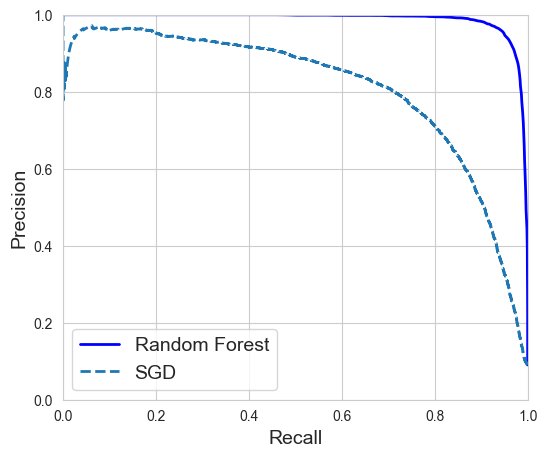

In [53]:
plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2,
         label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")

# extra code – just beautifies Figure 3–8
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.legend(loc="lower left")

plt.show()

The `RandomForestClassifier`’s PR curve looks much better than the `SGDClassifier`’s: it comes much closer to the top-right corner. Its F1 score and ROC AUC score are also significantly better:

In [54]:
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5  # positive proba ≥ 50%
f1_score(y_train_5, y_train_pred_forest)

0.9274509803921569

In [55]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [56]:
precision_score(y_train_5, y_train_pred_forest)

0.9897468089558485

In [57]:
recall_score(y_train_5, y_train_pred_forest)

0.8725327430363402

You now know how to train binary classifiers, choose the appropriate metric for your task, evaluate your classifiers using cross-validation, select the precision/recall trade-off that fits your needs, and use several metrics and curves to compare various models. You’re ready to try to detect more than just the 5s.